In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import os
import sys
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import seaborn as sns
from torch.nn import Parameter as P
from pathlib import Path

In [2]:
sys.path.append("..") 


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
RUNNING_ON_COLAB = False # in case of using colab 
data_path_electrs = '.'
data_path_photons = '.'
def_colab_path = './'
# Paths if runninc on colab
if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/gdrive', force_remount=False)

    def_colab_path = '/gdrive/My Drive/CaloGAN/'
    sys.path.append(def_colab_path)

    data_path_electrs = def_colab_path + 'data/CaloGAN_e_210000.root.npz'
    data_path_photons = def_colab_path + 'data/CaloGAN_gamma_210000.npz'
else:
    data_path_electrs = Path('./data/CaloGAN_e_210000.root.npz')
    data_path_photons   = Path('./data/CaloGAN_gamma_210000_val.root.npz')

#data_electrs = np.load(data_path_electrs, allow_pickle=False)
#data_photons = np.load(data_path_photons, allow_pickle=False)

In [6]:
from src.plotting_functions import *

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


Let's define Generator and Discriminator in order to load them states from pkl.

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, act_func = F.relu):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.activation = act_func

        # 128 + 5 -> (+reshape) 128 x 2 x 2
        self.fc1 = nn.Linear(self.z_dim + 5, self.z_dim * 2 * 2)

        # Z x 2 x 2
        self.conv1 = nn.ConvTranspose2d(self.z_dim, 128, 3, stride=2, padding=1, output_padding=1) 
        # 128 x 8 x 8
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        # 64 x 16 x 16
        self.conv3 = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        # 32 x 32 x 32
        self.conv4 = nn.ConvTranspose2d(32, 1,  3, stride=2, padding=1, output_padding=1)
        # 1 x 32 x 32
        # crop
        # 1 x 30 x 30

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))

        #print(x.shape)
        EnergyDeposit = x.view(-1, self.z_dim, 2, 2)

        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn1(self.conv1(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn2(self.conv2(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn3(self.conv3(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.conv4(EnergyDeposit))
        #print(EnergyDeposit.shape)
        EnergyDeposit = EnergyDeposit[:,:,1:31,1:31]
        #print(EnergyDeposit.shape)
                
        return EnergyDeposit


class Discriminator(nn.Module):
    def __init__(self, act_func = F.leaky_relu):
        super(Discriminator, self).__init__()
        self.activation = act_func

        # 30x30x1 -> 32x32x1 (padding)
        # 32x32x1
        self.conv1 = nn.Conv2d( 1,   32, 3, stride=2, padding=1)
        # 16x16x32
        self.conv2 = nn.Conv2d( 32,  64, 3, stride=2, padding=0)
        # 8x8x64
        self.conv3 = nn.Conv2d( 64, 128, 3, stride=2, padding=0)
        # 2x2x256
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=0)
        # 1x1x256
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=0)

        # 5x5x256 = 6400
        self.fc1 = nn.Linear(256 + 5, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        #print(EnergyDeposit.shape)
        X = self.activation(self.conv1(EnergyDeposit))
        #print(X.shape)
        X = self.activation(self.conv2(X))
        #print(X.shape)
        X = self.activation(self.conv3(X))
        #print(X.shape)
        X = self.activation(self.conv4(X))
        #print(X.shape)

        X = X.reshape(-1,256)
        #print(X.shape)
        X = torch.cat([X, ParticleMomentum_ParticlePoint], dim=1)
        #print(X.shape)
        
        X = F.leaky_relu(self.fc1(X))
        #print(X.shape)
        X = F.leaky_relu(self.fc2(X))
        #print(X.shape)

        if TASK in ['WASSERSTEIN', 'HINGE']:
            return self.fc3(X)
        else:
            return torch.sigmoid(self.fc3(X))

In [9]:
model_filename= 'example_model_wgan.pt'

In [10]:
model = None
with open(def_colab_path + model_filename, 'rb') as pickle_file:
  model = pickle.load(pickle_file)

Here you can see the pretrained generator.

In [20]:
model.generator

Generator(
  (fc1): Linear(in_features=261, out_features=1024, bias=True)
  (conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Now there are some additional attributes inside the model object, but for all the future experiments we can share only the generator class and load state_dict.

In [21]:
model.generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0368,  0.0467,  0.1061,  ..., -0.0132, -0.0300,  0.1202],
                      [ 0.0344,  0.0121,  0.0123,  ..., -0.1190,  0.0340, -0.0373],
                      [ 0.0064,  0.0390,  0.0152,  ..., -0.0846,  0.0553,  0.0703],
                      ...,
                      [ 0.0650, -0.0578,  0.0094,  ..., -0.0987, -0.0289, -0.0735],
                      [ 0.0048,  0.0208, -0.0049,  ..., -0.1175, -0.0461, -0.0165],
                      [ 0.0078,  0.0758,  0.0670,  ..., -0.1337,  0.1252, -0.1057]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.0139, -0.1780, -0.0395,  ..., -0.0552, -0.1202,  0.0783],
                     device='cuda:0')),
             ('conv1.weight',
              tensor([[[[ 0.0105, -0.0287,  0.0349],
                        [-0.0104, -0.0179,  0.0812],
                        [ 0.0301, -0.0114,  0.0908]],
              
                       [[ 0.0369,  0.0352, -0.

As an example of the input lets take a sample from the validatation dataset (it is also stored in model object).

In [15]:
energy, mom, point, pdg = model.valid_dataloader.dataset[:1]

In [71]:
energy, mom, point, pdg = energy.to(model.device), mom.to(model.device), point.to(model.device), pdg.to(model.device)

Let's generate an output using forward.

In [72]:
energy_gen = model.generator(torch.randn(len(energy), model.noise_dim).to(model.device),
                              torch.cat([mom.to(model.device), point.to(model.device)], dim=1))

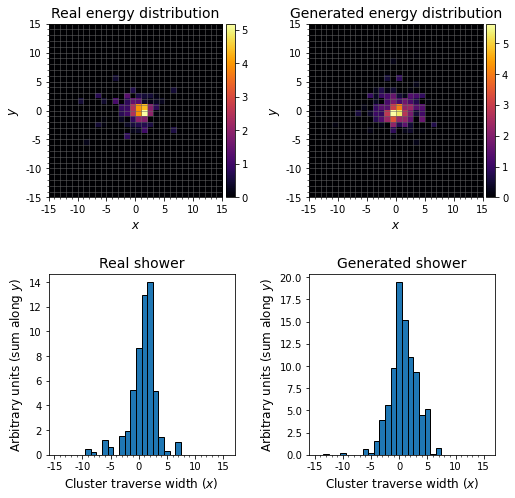

In [73]:
plot_energy_and_shower(energy.detach().cpu()[0],energy_gen.detach().cpu()[0])

Let's redifine forward for trace.

In [58]:
class Generator(nn.Module):
    def __init__(self, z_dim, act_func = F.relu):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.activation = act_func

        # 128 + 5 -> (+reshape) 128 x 2 x 2
        self.fc1 = nn.Linear(self.z_dim + 5, self.z_dim * 2 * 2)

        # Z x 2 x 2
        self.conv1 = nn.ConvTranspose2d(self.z_dim, 128, 3, stride=2, padding=1, output_padding=1) 
        # 128 x 8 x 8
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        # 64 x 16 x 16
        self.conv3 = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        # 32 x 32 x 32
        self.conv4 = nn.ConvTranspose2d(32, 1,  3, stride=2, padding=1, output_padding=1)
        # 1 x 32 x 32
        # crop
        # 1 x 30 x 30

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

    def forward(self, x):
        #x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))

        #print(x.shape)
        EnergyDeposit = x.view(-1, self.z_dim, 2, 2)

        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn1(self.conv1(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn2(self.conv2(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn3(self.conv3(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.conv4(EnergyDeposit))
        #print(EnergyDeposit.shape)
        EnergyDeposit = EnergyDeposit[:,:,1:31,1:31]
        #print(EnergyDeposit.shape)
                
        return EnergyDeposit


You can work with generator only.

In [59]:
gen = Generator(model.noise_dim)

In [36]:
gen.load_state_dict(torch.load('gen.pt'))

<All keys matched successfully>

In [39]:
sample = torch.cat([torch.randn(len(energy), model.noise_dim).to(model.device),
                              torch.cat([mom.to(model.device), point.to(model.device)], dim=1)],dim = 1)

So, let's trace the model using sample.

In [76]:
scripted_model = torch.jit.trace(gen.to('cpu'), sample.to('cpu'))

In [77]:
scripted_model.save('gen_script_cpu.pth')

Testing it.

In [81]:
x = torch.rand([1,261])

In [78]:
test = torch.jit.load('gen_script_cpu.pth')

In [84]:
test(x.to('cpu')) == gen(x.to('cpu'))

tensor([[[[True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, Tr

Outpus are same.